In [30]:
#!/usr/bin/env python
"""
--------------------------------------------------------------------------
Created June 20, 2023 for TRIPs-Py library
"""
__author__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha and Connor Sanderford"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and "

In [31]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
##Specify the font
##Latex needs to be installed! If not installed, please comment the following 5 lines
parameters = {'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'axes.titlesize': 18, 'axes.labelsize': 18, 'figure.titlesize': 14, 'legend.fontsize': 13}
plt.rcParams.update(parameters)
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
# import phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.utilities.testProblems import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
import requests
from scipy import sparse
import numpy as np
import h5py
from trips.utilities.utils import *
# functions to generate emoji data are stored in io_l.py
from trips.utilities.io import *
from trips.utilities.operators import *
from trips.solvers.AnisoTV import *
from trips.utilities.helpers import *
from scipy import sparse

# Notebook 1: CrossPhantom test problem

<p>In this example we illustrate the following:
<p>&nbsp; Step 1: Download/read the crossPhantom data and prepare them for processing.
<p>&nbsp; Step 2: Solve the static inverse problem.
<p>&nbsp; Step 3: Solve the dynamic inverse problem.

CrossPhantom data are generated at the University of Helsinki: https://zenodo.org/record/1341457

#### Step 1: Download/read the data and prepare them for processing
##### The main function to generate the emoji data is generate_crossPhantom(dataset, noise_level) 
<p> <b>Input:</b> 
<p>&nbsp; <b>dataset:</b>
        <p>&nbsp; if dataset = 15, we generate data from DataDynamic_128x15.mat
        <p>&nbsp; if dataset = 60, we generate data from DataDynamic_128x60.mat
<p>&nbsp; <b>noise_level:</b>
        <p>&nbsp; CrossPhantom data are real data and they have noise. Hence, we set noise_level = 0
            
<p> <b>Output:</b>  
&nbsp;<br> <b>A:</b> The full forward operator for all time instances<br>
&nbsp; <b>b:</b> All the data/measurements vectorized<br> 
&nbsp; <b>AA:</b> A list of 16 time-wise operators<br> 
&nbsp; <b>B:</b> A list of 16 data vectors for each time instance <br> 
&nbsp; <b>nx:</b> The dimension of the first spatial domain<br> 
&nbsp; <b>ny:</b> The dimension of the second spatial domain<br> 
&nbsp; <b>nt:</b> The dimension of the time instances domain<br> 
&nbsp; <b>delta:</b> The noise level in the data. When we set noise_level == 0, we get delta = 0<br> 
&nbsp; <b>sinoshape:</b> The dimension of the time-wise sinogram<br>     

In [32]:
(A, b, AA, B, nx, ny, nt, delta) = generate_crossPhantom(noise_level = 0.001, dataset = 15)

Data already downloaded.


In [33]:
delta

0.11942484939693127

In [34]:
A.shape

(11200, 262144)

In [62]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
# L = spatial_derivative_operator(nx, ny, nt)
L = gen_spacetime_derivative_operator(nx, ny, nt)
# data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, b, L, pnorm=2, qnorm=1, projection_dim=1, n_iter =6, regparam = 'dp', x_true = None, delta = delta)

running MMGKS...: 100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


In [65]:
xx = x_mmgks.reshape((nx, ny, nt))

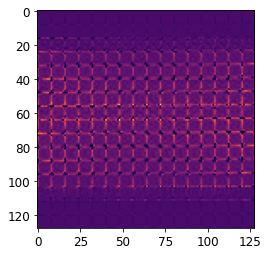

In [67]:
plt.imshow(xx[:, :, 1])

#### Import and plot the ground truth image

In [28]:
f = spio.loadmat(f'./data/crossphantom_data/GroundTruthReconstruction2D.mat')

FileNotFoundError: [Errno 2] No such file or directory: './data/crossphantom_data/GroundTruthReconstruction2D.mat'

(-0.5, 2047.5, 2047.5, -0.5)

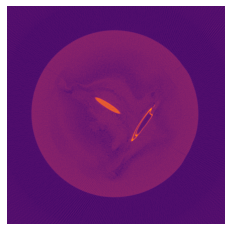

In [36]:
plt.imshow(f['recon'], cmap = 'inferno')
plt.axis('off')

### Show the sinogram for all the data 

(-0.5, 139.5, 79.5, -0.5)

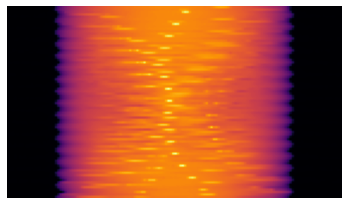

In [37]:
plt.imshow(b.reshape((80, 140)), cmap = 'inferno')
plt.axis('off')

### Show the sinogram for the first time instance 

In [38]:
plt.imshow(B[0].reshape((5, 140)), cmap = 'inferno')
plt.axis('off')

(-0.5, 139.5, 4.5, -0.5)

#### Step 2: Solve the static inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [7]:
regvals = [1*(0.9**(x)) for x in range(0,10)]

In [68]:
xx = AnisoTV(A, b, AA, B, nx, ny, nt, dynamic = False, iters = 10, reg_param = 'gcv', testproblem  = 'CrossPhantom', delta = delta)

running MMGKS...: 100%|██████████| 10/10 [00:00<00:00, 15.35it/s]


ValueError: not enough values to unpack (expected 4, got 2)

#### Plot reconstructed images one by one

In [69]:
time_instance = 15
plt.imshow(xx[time_instance].reshape((nx, ny)), cmap = 'inferno')
plt.axis('off')

ValueError: cannot reshape array of size 2048 into shape (128,128)

<Figure size 432x288 with 0 Axes>

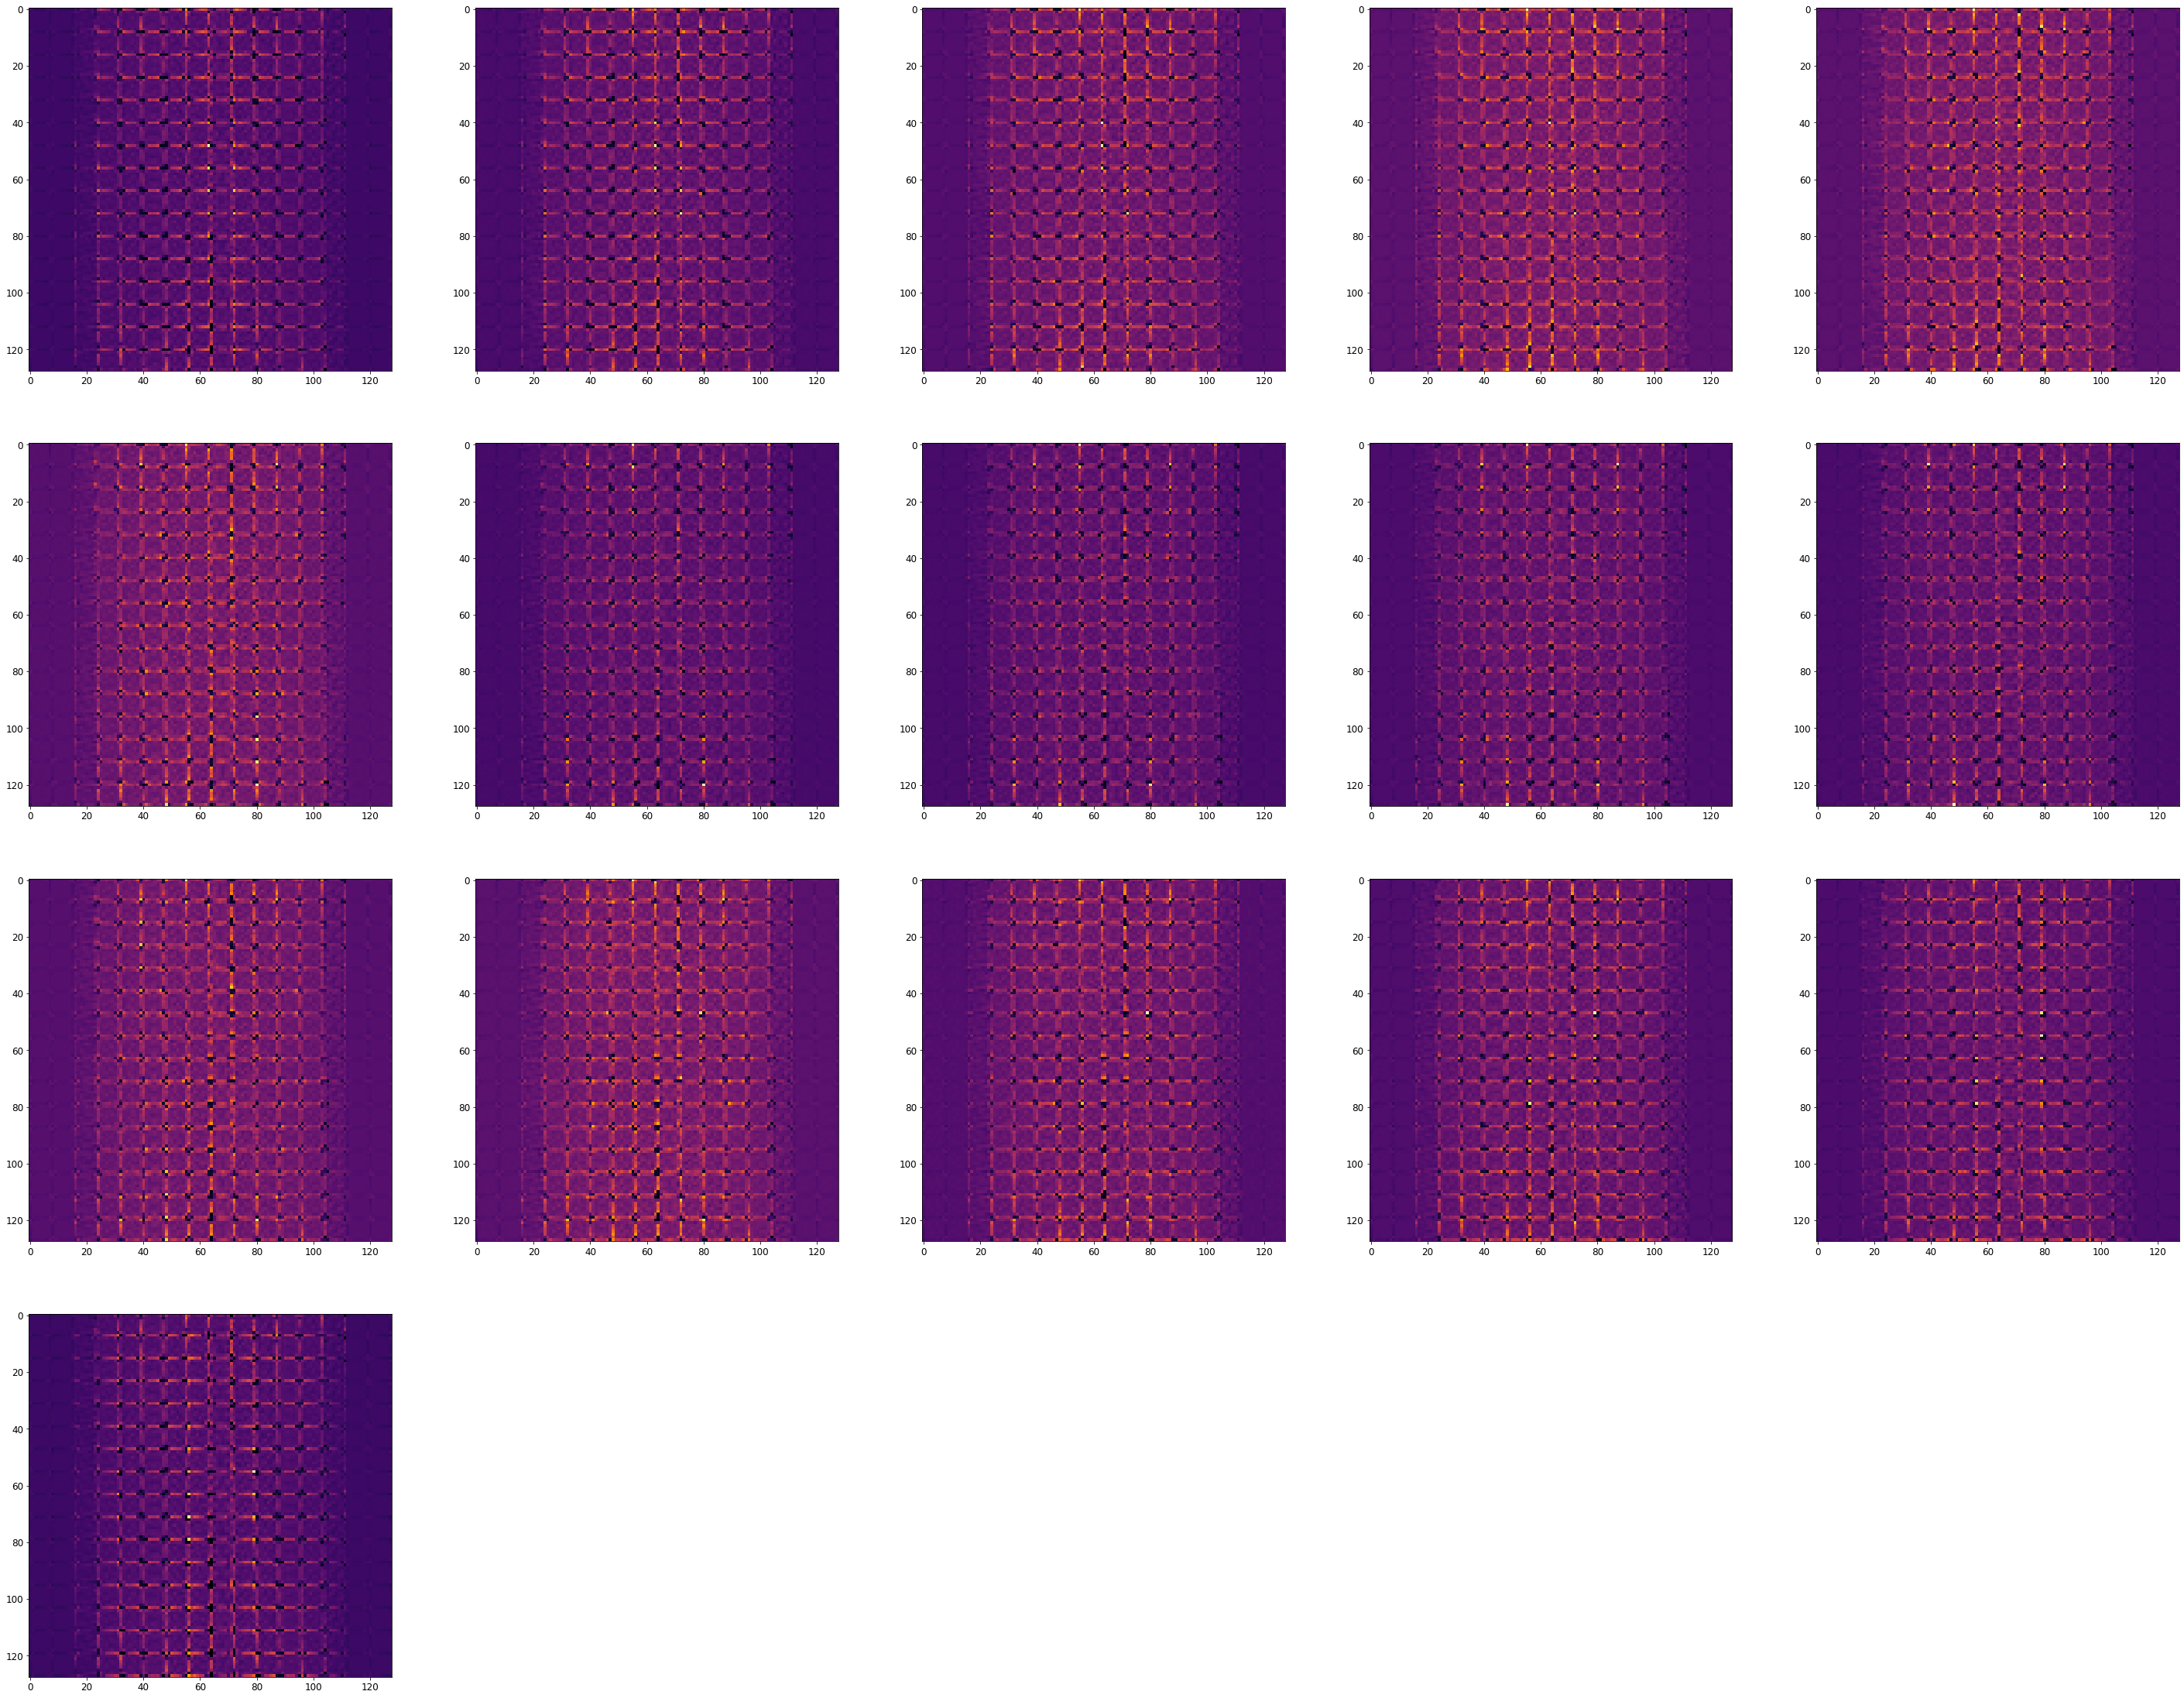

In [70]:
plot_recstructions_series(xx, (nx, ny, nt), dynamic = True, testproblem = 'crossPhantom', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/CrossPhantom')

#### Step 3: Solve dynamic inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [39]:
regvals = [1.5*(0.9**(x)) for x in range(0,10)]

In [23]:
def AnisoTV(A, b, AA, B, nx, ny, nt, dynamic, iters, reg_param, testproblem, delta, **kwargs):
    """
    Reconstruct images by Anisotropic Total Variation
    """
    if testproblem == 'gelPhantom':
        if dynamic == True:
            b_vec = b.reshape((-1,1))
            L = spatial_derivative_operator(nx, ny, nt)
            (x, info) = MMGKS(A, b_vec, L, pnorm=2, qnorm=1, projection_dim=3, n_iter = iters, regparam=reg_param, x_true=None, **kwargs)
#            xx = np.reshape(x, (nx, ny, nt), order="F")
        else:
            xx = list(range(nt))
            L = first_derivative_operator_2d(nx, ny)
            for i in range(nt):
                b_vec = B[:, i].reshape((-1,1))
                (x, x_history, lambdah, lambda_history) = MMGKS(AA[i], b_vec, L, pnorm=2, qnorm=1, projection_dim=3, n_iter = iters, regparam=reg_param, x_true=None, **kwargs)
                xx[i] = x
    elif testproblem in ['STEMPO', 'Stempo', 'stempo']:
        if dynamic == True:
            b_vec = b.reshape((-1,1))
            L = spatial_derivative_operator(nx, ny, nt)
            (x, info) = MMGKS(A, b_vec, L, pnorm=2, qnorm=1, projection_dim=3, n_iter = iters, regparam=reg_param, x_true=None, **kwargs)
            xx = np.reshape(x, (nx, ny, nt), order="F")
        else:
            xx = list(range(nt))
            L = first_derivative_operator_2d(nx, ny)
            for i in range(nt):
                print(i)
                b_vec = B[:, i].reshape((-1,1))
                (x, info) = MMGKS(AA[i], b_vec, L, pnorm=2, qnorm=1, projection_dim=3, n_iter = iters, regparam=reg_param, x_true=None, **kwargs)
                xx[i] = x
    else:
        if dynamic == True:
            b_vec = b.reshape((-1,1))
            L = spatial_derivative_operator(nx, ny, nt)
            # L = time_derivative_operator(nx, ny, nt)
            (x, info) = MMGKS(A, b_vec, L, pnorm=2, qnorm=1, projection_dim=1, n_iter = iters, regparam=reg_param, x_true=None,  **kwargs)
            xx = np.reshape(x, (nx, ny, nt), order="F")
        else:
            xx = list(range(nt))
            # L = spatial_derivative_operator(nx, ny, 1)
            L = first_derivative_operator_2d(nx, ny)
            for i in range(nt):
                b_vec = B[i].reshape((-1,1))
                (x, info) = MMGKS(AA[i], b_vec, L, pnorm=2, qnorm=1, projection_dim=3, n_iter = iters, regparam=reg_param, x_true=None, **kwargs)
                xx[i] = x
    return xx  

In [27]:
x_AnisoTV = AnisoTV(A, b, AA, B, nx, ny, nt, dynamic = True, iters = 20, reg_param = 'dp', testproblem = 'CrossPhantom', delta = delta)

running MMGKS...:   0%|          | 0/20 [00:00<?, ?it/s]


Exception: A value for the noise level delta was not provided and the discrepancy principle cannot be applied. 
                    Please supply a value of delta based on the estimated noise level of the problem, or choose the regularization parameter according to gcv.

#### Plot reconstruction images of the dynamic problem

(-0.5, 127.5, 127.5, -0.5)

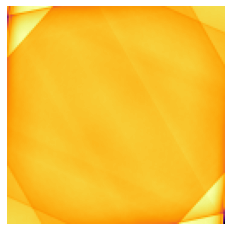

In [25]:
time_instance = 15
plt.imshow(x_AnisoTV[:, :, time_instance].reshape((nx, ny)), cmap = 'inferno')
plt.axis('off')

<Figure size 432x288 with 0 Axes>

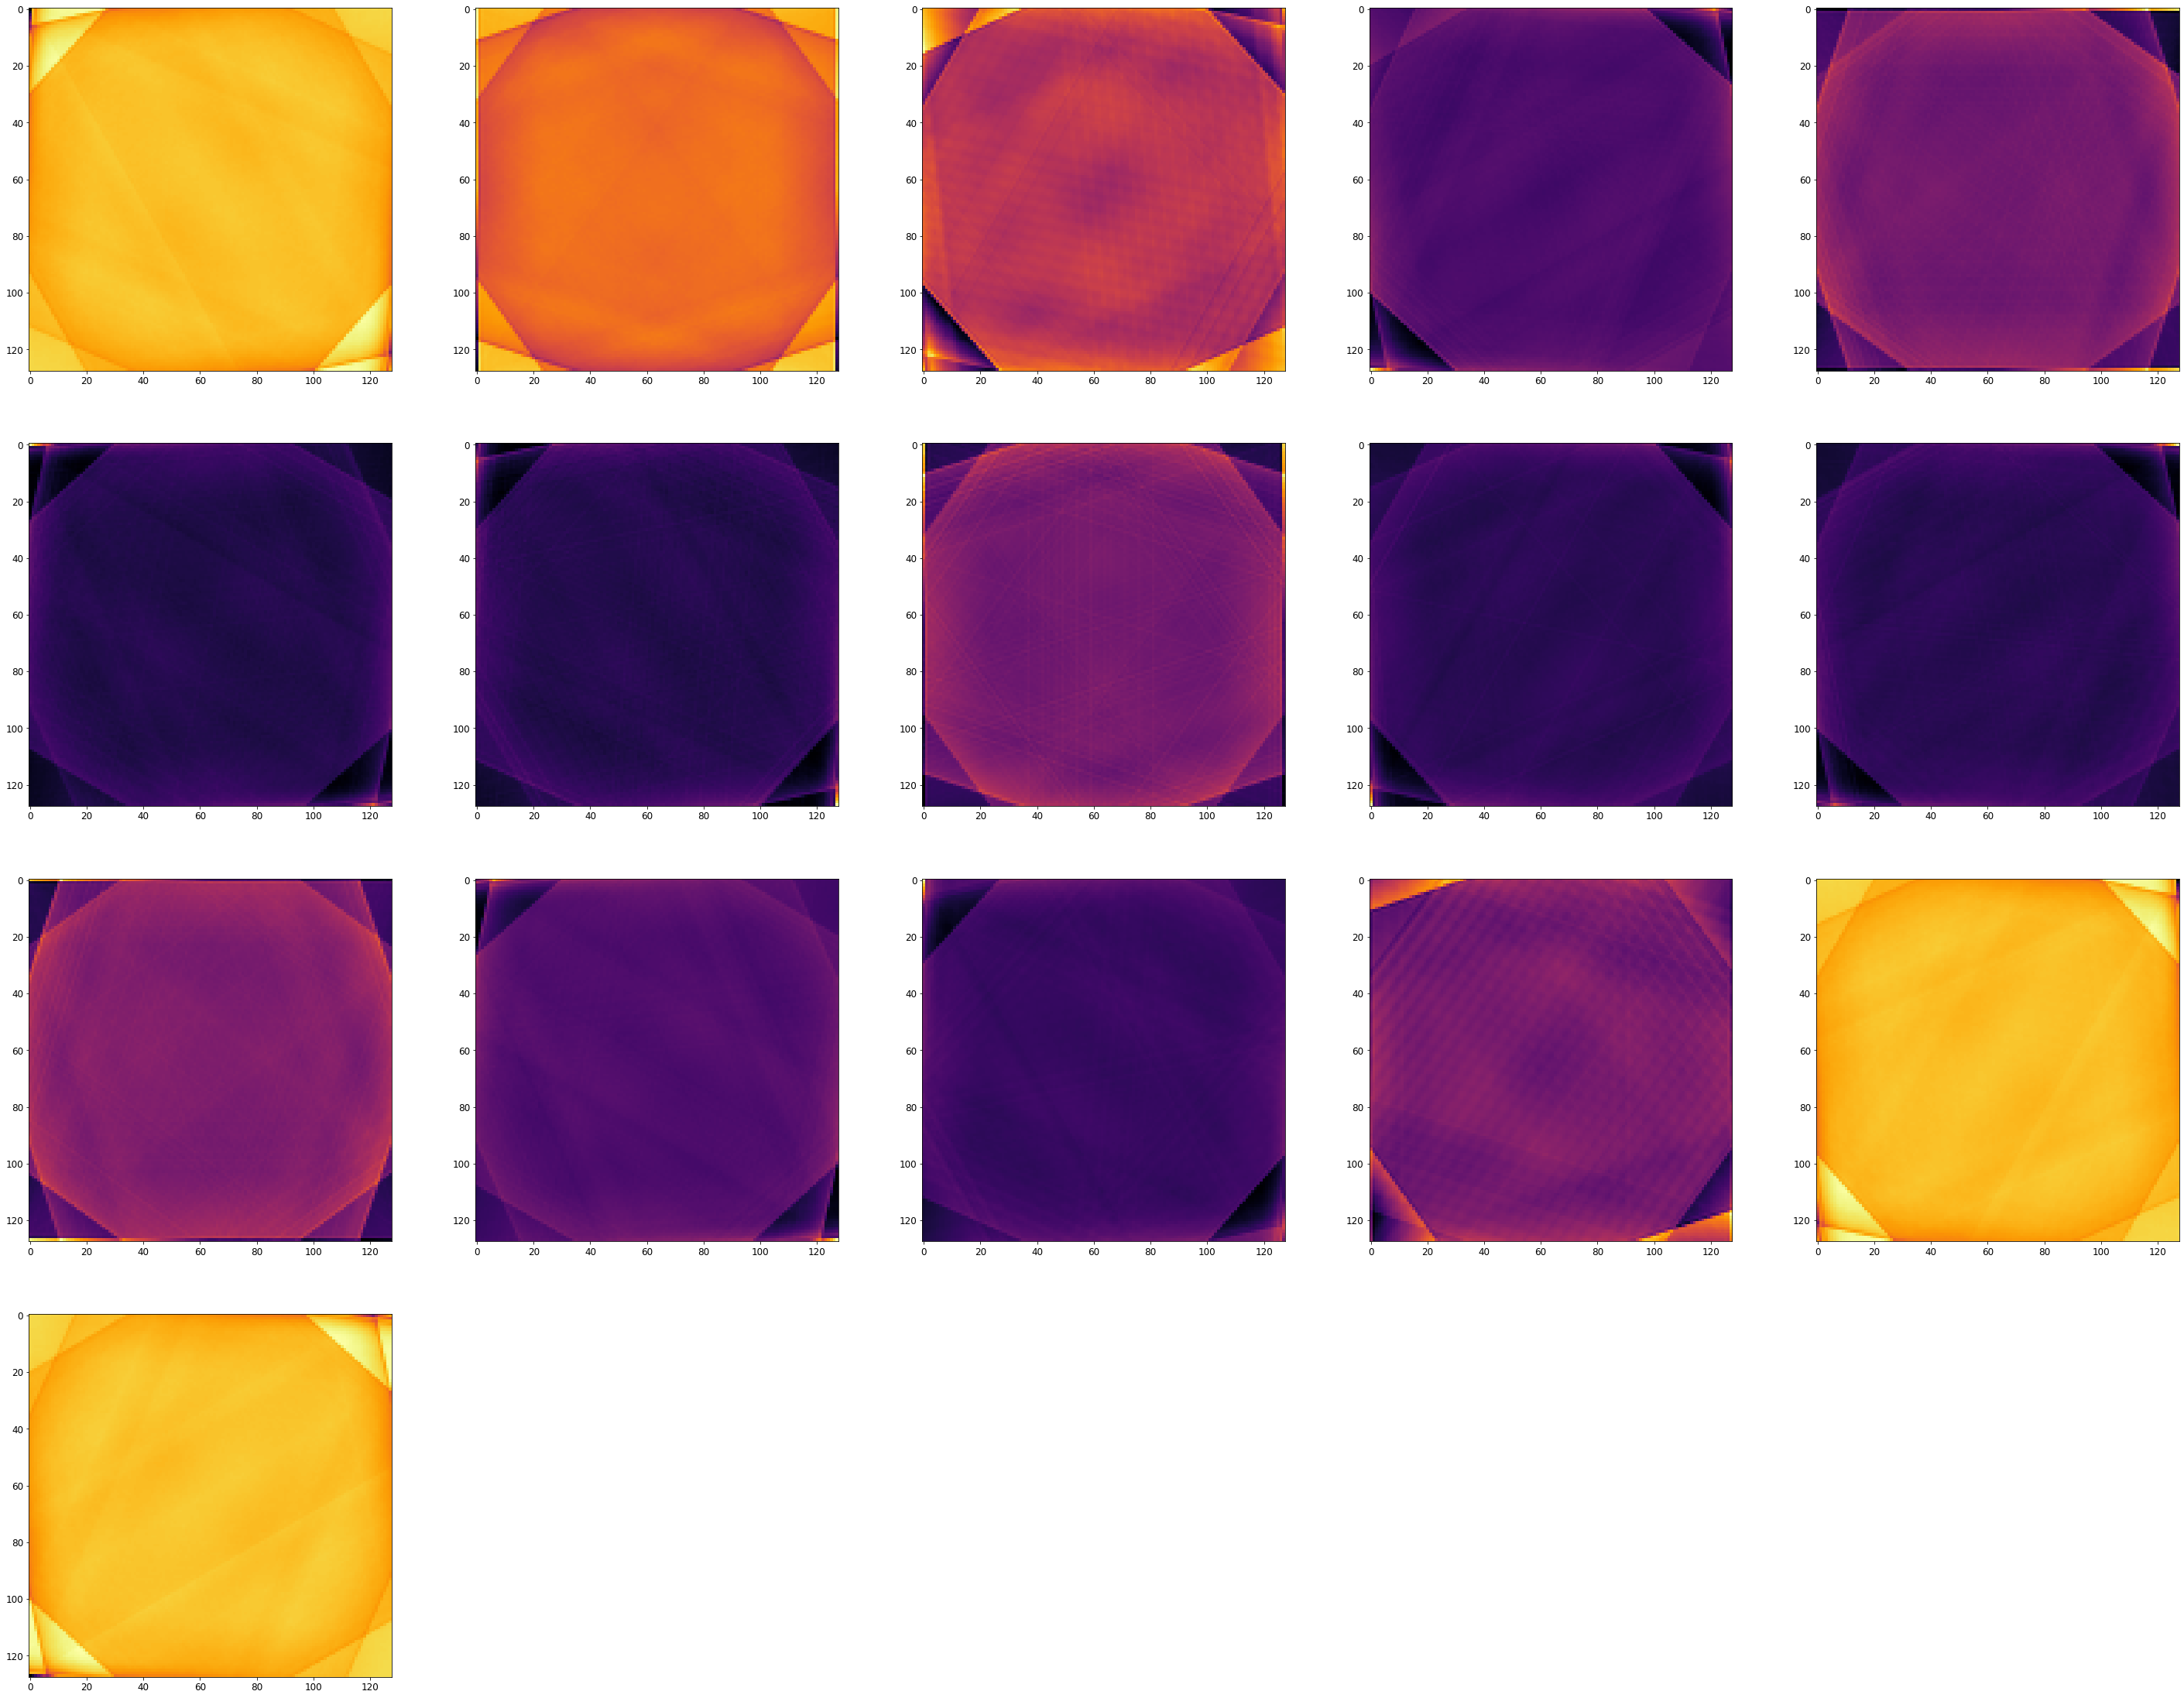

In [26]:
plot_recstructions_series(x_AnisoTV, (nx, ny, nt), dynamic = True, testproblem = 'CrossPhantom', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/CrossPhantom')

#### Step 4: Solve the problem by Golub-Kahan

generating basis...: 100%|██████████| 10/10 [00:00<00:00, 27.77it/s]


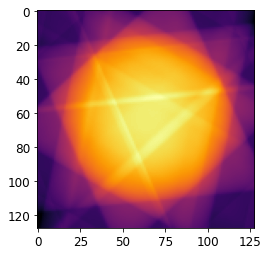

In [26]:
b_vec = b.reshape((-1,1))
projection_dim = 10
(U, B, V) = generalized_golub_kahan(A, b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = B[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)
x_GKahan = np.reshape(x_GKahan, (nt, nx, ny))
x_GKahan.shape
plt.imshow(x_GKahan[15, :, :])